<a href="https://colab.research.google.com/github/matthewpecsok/4482_fall_2024/blob/main/tutorials/decision_tree_sklearn_titanic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Decision Tree titanic tutorial




## table of contents

1.   Data Description
2.   Set up, data import and inspections
3.   Pre-model-building data exploration
4.   Build decision trees
5.   Generate performance metrics




# 1 Data Description
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people such as women, children, and the upper-class were more likely to survive than others.

VARIABLE DESCRIPTIONS:

PassengerID Unique passenger identifier

Survived Survival (0 = No; 1 = Yes)

Pclass Passenger Class(1 = 1st; 2 = 2nd; 3 = 3rd)
(Pclass is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower)

Name Name

Sex Sex

Age Age (Age is in Years; Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5)

Sibsp Number of Siblings/Spouses Aboard

Parch Number of Parents/Children Aboard

Ticket Ticket Number

Fare Passenger Fare

Cabin Cabin

Embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# 2 Set up, data import and inspections

## load libraries

In [1]:
## Load packages

import pandas as pd
import numpy as np
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt



## import data

In [2]:
# read_csv has some defaults, we can just take the defaults here, but be aware they exist.
titanic_raw = pd.read_csv("https://raw.githubusercontent.com/matthewpecsok/4482_fall_2024/main/data/titanic_cleaned.csv")
titanic = titanic_raw.copy()

# raw is the original unedited version of our data which can be useful for inspecting changes we've made
# compared to the original unedited data

## get summary statistics of dataframe

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Sex       714 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    int64  
 5   Parch     714 non-null    int64  
 6   Fare      714 non-null    float64
 7   Cabin     714 non-null    object 
 8   Embarked  714 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 50.3+ KB


In [4]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,missing,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,missing,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,missing,S


In [5]:
titanic.describe(include='all')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
count,714.000000,714.000000,714,714.000000,714.000000,714.000000,714.000000,714,714
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,135,4
top,NaN,NaN,male,NaN,NaN,NaN,NaN,missing,S
freq,NaN,NaN,453,NaN,NaN,NaN,NaN,529,554
mean,0.406162,2.236695,NaN,29.699118,0.512605,0.431373,34.694514,NaN,NaN
std,0.491460,0.838250,NaN,14.526497,0.929783,0.853289,52.918930,NaN,NaN
min,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,1.000000,NaN,20.125000,0.000000,0.000000,8.050000,NaN,NaN
50%,0.000000,2.000000,NaN,28.000000,0.000000,0.000000,15.741700,NaN,NaN
75%,1.000000,3.000000,NaN,38.000000,1.000000,1.000000,33.375000,NaN,NaN


In [6]:
# count null values (extremely important to identify nulls)

titanic.isnull().sum()

# no nulls, that's good news and almost never what happens in the real world.

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Cabin,0
Embarked,0


In [7]:
titanic.Survived.value_counts()

,count
Survived,
0,424
1,290


In [8]:
titanic.Survived.value_counts(normalize=True)

,proportion
Survived,
0,0.593838
1,0.406162


In [9]:
round(titanic.Survived.value_counts() / len(titanic),2)

,count
Survived,
0,0.59
1,0.41


## transform character/string to categorical

In [10]:
# astype is function in pandas that allows one to convert from one type of data to another ie string to int, or in this
# case string to categorical
# https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html

titanic = titanic.astype({'Survived': 'category',
                                          'Sex': 'category',
                                          'Pclass': 'category',
                                          'Cabin': 'category',
                                          'Embarked': 'category'})
titanic.dtypes

,0
Survived,category
Pclass,category
Sex,category
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Cabin,category
Embarked,category


## dummy encode the data

these models cannot handle string/words. they must be converted to numeric values

In [11]:
# extract the target column of survived. target aka y
# while R is happy to have the target in the dataframe with the X predictors sklearn prefers them separate
y_target = titanic.pop('Survived')

# use pandas get_dummies to one-hot-encode categorical values
# we would expect only numeric values left in our dataframe
# rename this df as encoded so we understand it's the encoded version
# of the original
titanic_encoded_X = pd.get_dummies(titanic)

titanic_encoded_X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_A10,...,Cabin_F2,Cabin_F33,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,22.0,1,0,7.2500,False,False,True,False,True,False,...,False,False,False,False,False,True,False,False,True,False
1,38.0,1,0,71.2833,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,26.0,0,0,7.9250,False,False,True,True,False,False,...,False,False,False,False,False,True,False,False,True,False
3,35.0,1,0,53.1000,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
4,35.0,0,0,8.0500,False,False,True,False,True,False,...,False,False,False,False,False,True,False,False,True,False


In [12]:
# lucky for us the binary target values are already numeric ie 0,1 instead of "yes","no" "true","false" etc
# this saves us a step of having to encode the series.
y_target

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
709,0
710,0
711,1
712,1


# 3 Pre-model-building data exploration

In [13]:
# generate metrics for male and female passengers. in this notebook we will demonstrate doing what was done in R,
# but in this case we will use a function to simplify the code
# often when doing the same thing 2 or more times a function can reduce redundant code

In [14]:
titanic[titanic['Sex']=='male'] # demonstration of how to filter a dataframe

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,missing,S
4,3,male,35.0,0,0,8.0500,missing,S
5,1,male,54.0,0,0,51.8625,E46,S
6,3,male,2.0,3,1,21.0750,missing,S
11,3,male,20.0,0,0,8.0500,missing,S
...,...,...,...,...,...,...,...,...
707,2,male,28.0,0,0,10.5000,missing,S
708,3,male,25.0,0,0,7.0500,missing,S
710,2,male,27.0,0,0,13.0000,missing,S
712,1,male,26.0,0,0,30.0000,C148,C


In [15]:
def metrics_by_gender(gender,df):
  # filter df by gender
  display("Dataframe subset of: "+gender)

  df = df[df['Sex']==gender]

  print(gender+": shape")
  display(df.shape)

  print(gender+": describe")
  display(df.describe())


In [16]:
# demonstration of a very simple function that just subsets the dataframe and prints the new shape
for gender in ['male','female']:
  df = titanic[titanic['Sex']==gender]
  print(gender)
  print(df.shape)
  print()

male
(453, 8)

female
(261, 8)



In [17]:
# demonstration of a very simple function that just subsets the dataframe and prints the new shape
for gender in ['male','female']:
  df = titanic[titanic['Sex']==gender]
  print(gender)
  print(df.describe())
  print()

male
              Age       SibSp       Parch        Fare
count  453.000000  453.000000  453.000000  453.000000
mean    30.726645    0.439294    0.271523   27.268836
std     14.678201    0.923609    0.651076   45.841889
min      0.420000    0.000000    0.000000    0.000000
25%     21.000000    0.000000    0.000000    7.895800
50%     29.000000    0.000000    0.000000   13.000000
75%     39.000000    1.000000    0.000000   28.500000
max     80.000000    5.000000    5.000000  512.329200

female
              Age       SibSp       Parch        Fare
count  261.000000  261.000000  261.000000  261.000000
mean    27.915709    0.639847    0.708812   47.582759
std     14.110146    0.928493    1.066752   61.346854
min      0.750000    0.000000    0.000000    6.750000
25%     18.000000    0.000000    0.000000   13.000000
50%     27.000000    0.000000    0.000000   26.000000
75%     37.000000    1.000000    1.000000   57.979200
max     63.000000    5.000000    6.000000  512.329200



In [18]:
# demonstration of a very simple function that just subsets the dataframe and prints the new shape
for gender in ['male','female']:
  df = titanic_raw[titanic_raw['Sex']==gender]
  print(gender)
  #print(df.groupby('Survived').value_counts())
  print(df.groupby(['Survived','Pclass'])[['Pclass']].agg(['count']))
  print()

male
                Pclass
                 count
Survived Pclass       
0        1          61
         2          84
         3         215
1        1          40
         2          15
         3          38

female
                Pclass
                 count
Survived Pclass       
0        1           3
         2           6
         3          55
1        1          82
         2          68
         3          47



In [19]:
for gender in ['male','female']:
  df = titanic_raw[titanic_raw['Sex']==gender]
  print(gender)
  #print(df.groupby('Survived').value_counts())
  print(df.groupby(['Survived','Embarked'])[['Embarked']].agg(['count']))
  print()

male
                  Embarked
                     count
Survived Embarked         
0        C              45
         Q              15
         S             300
1        C              24
         Q               1
         S              68

female
                  Embarked
                     count
Survived Embarked         
0        C               6
         Q               5
         S              53
1        C              55
         Q               7
         S             133
         missing         2



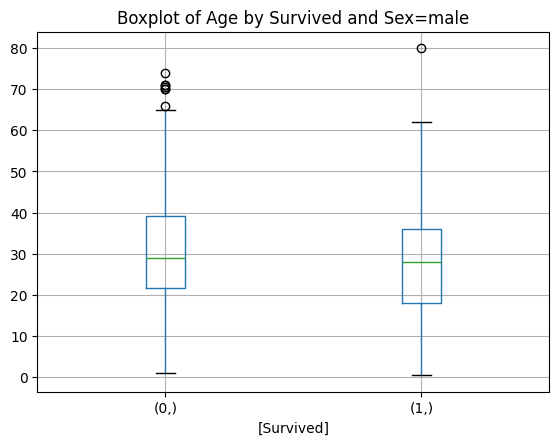

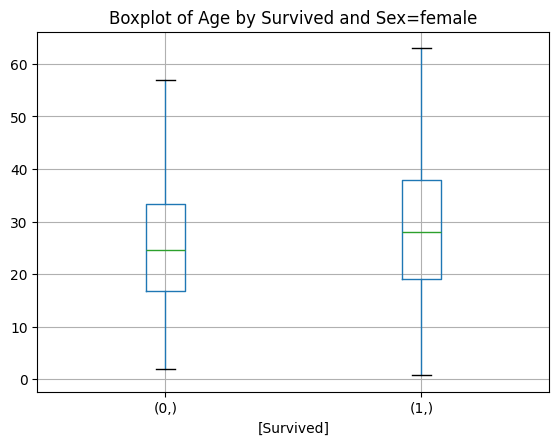

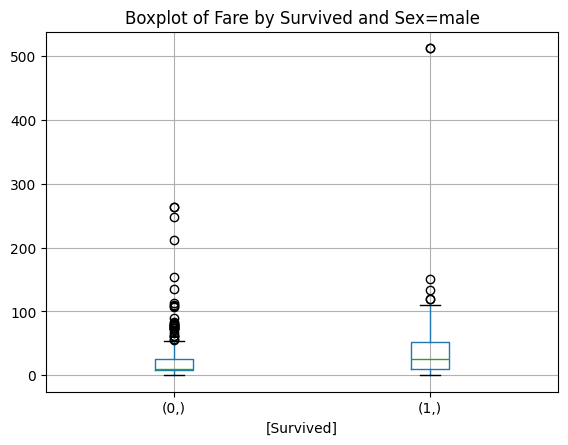

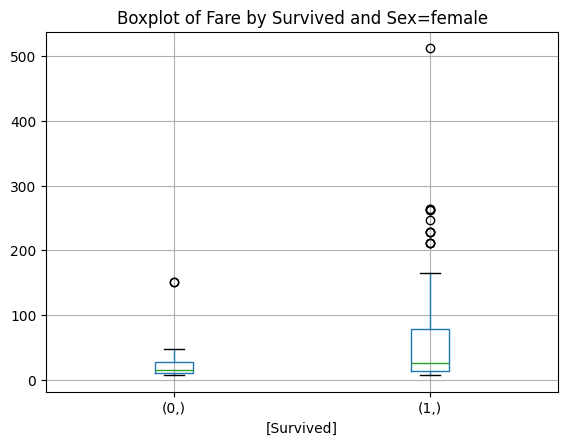

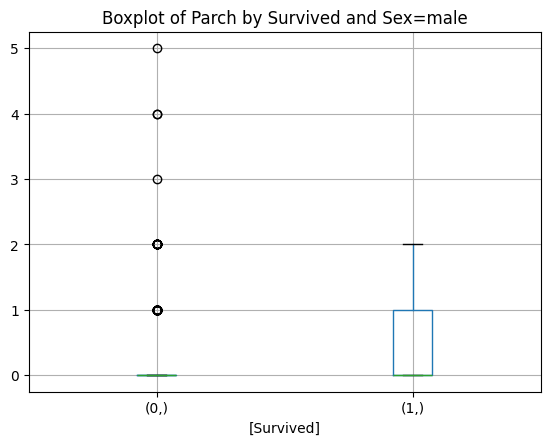

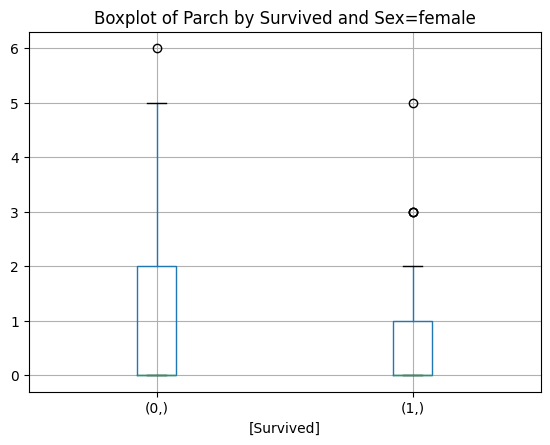

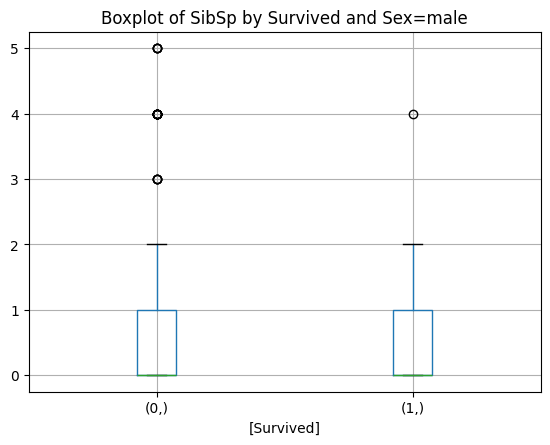

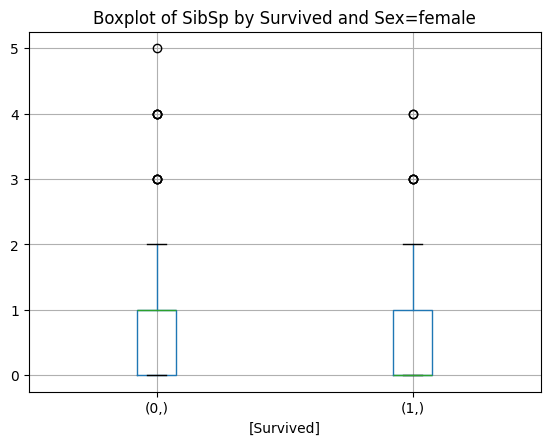

In [20]:
# demonstrating a nested for loop
# be careful of going much deeper than this in a loop
# the code becomes very difficult to read
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   # ignore some ugly warnings because of code that is being deprecated

for numeric_var in ['Age','Fare','Parch','SibSp']:
  for gender in ['male','female'] :
    df = titanic_raw[titanic_raw['Sex']==gender]
    df.boxplot(column=[numeric_var],by=['Survived']) # R boxplot(Age~Survived, data = titanic)
    plt.title( 'Boxplot of %s by Survived and Sex=%s' % (numeric_var,gender) )
    plt.suptitle('')
    plt.show()


# 4 build decision trees

In [21]:
# random state
# set random state for all models for reproducbility
# if this is NOT set then you will see variations each time you run the model
# for this reason reproducibility is desirable in homeworks
random_state = 42

In [22]:
# what is tree?
tree

# an instance of a sklearn tree classifier

<module 'sklearn.tree' from '/usr/local/lib/python3.11/dist-packages/sklearn/tree/__init__.py'>

In [23]:
tree_model_1 = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=.10)
tree_model_1

DecisionTreeClassifier(ccp_alpha=0.1, random_state=42)

**Model Defaults**

When instantiating any model some model settings will be set at the "Default" unless you choose to override them by passing in parameters to the model instantiation. For example, if we had NOT overridden ccp_alpha it would have been set to 0 by default and no pruning would have been done on the tree.

For any method that you are intending to run it can be useful (and is often critical) to be aware of what defaults you are taking if you chose to not override them. To see this you can read the method documentation. Simply mouse over the method and wait a moment. The method documentation will appear.

Shown below are the parameters the method expects and the default values you will be receiving if you don't pass anything in. For example the `criterion` will default to `'gini'`, and the `min_samples_split` will default to `2`.

In future assignments you may be asked to build a DecisionTree or some other model with instructions like 'build a decision tree, take the model defaults' in that case you will instantiate the model without passing any parameters into the method which will allow you to use the defaults.


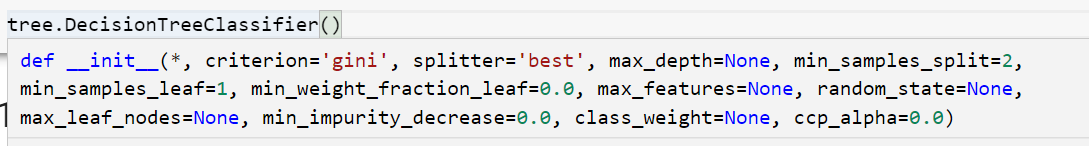

In [24]:
tree.DecisionTreeClassifier() # this model can be said to have been created with the model Defaults

DecisionTreeClassifier()

## model 1 (all data)

### fit/train the model

In [25]:
# note, there is a lot going on behind the scenes here fitting is a complex process
# the first argument is a dataset of the predictors. the second is a series of the target or y variable.
tree_model_1 = tree_model_1.fit(titanic_encoded_X,y_target) # this trains the model on the x and y data

### plot the tree

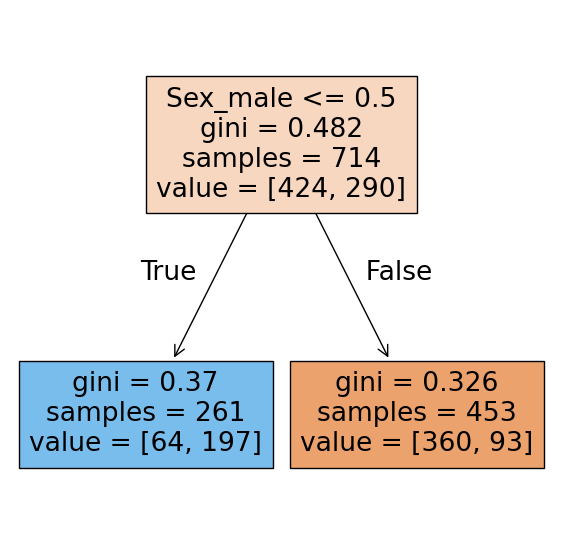

In [26]:
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(tree_model_1,
                   feature_names=titanic_encoded_X.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

## model 2

In [27]:
# create a new model 2
tree_model_2 = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=0.02)
tree_model_2

# note, there is a lot going on behind the scenes here fitting is a complex process
tree_model_2 = tree_model_2.fit(titanic_encoded_X,y_target) # this trains the model on the x and y data


### plot the tree

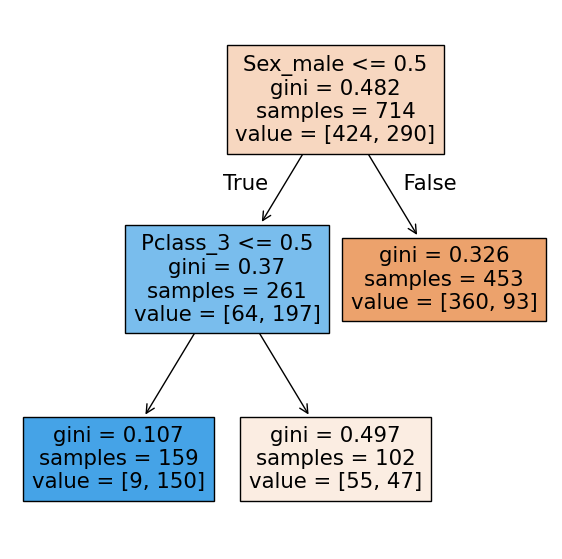

In [28]:
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(tree_model_2,
                   feature_names=titanic_encoded_X.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

## model 3

In [29]:
# create a new model 2
tree_model_3 = tree.DecisionTreeClassifier(random_state=random_state,ccp_alpha=0.0002)
tree_model_3

# note, there is a lot going on behind the scenes here fitting is a complex process
tree_model_3 = tree_model_3.fit(titanic_encoded_X,y_target) # this trains the model on the x and y data


plot the tree

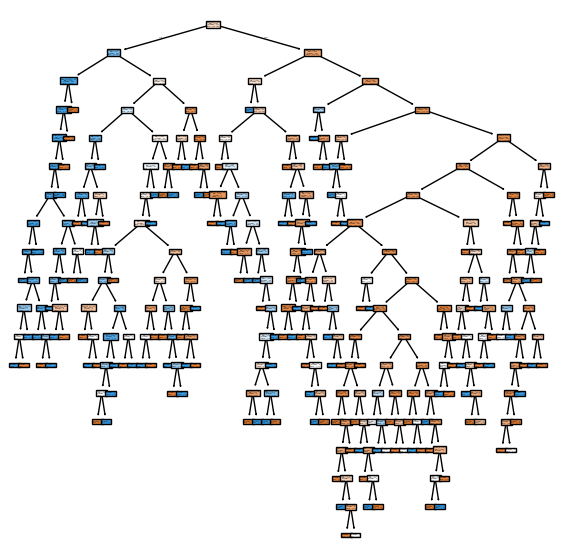

In [30]:
fig = plt.figure(figsize=(7,7))
_ = tree.plot_tree(tree_model_3,
                   feature_names=titanic_encoded_X.columns.to_list(), # make sure the feature names are in output
                   filled=True) # filled true color codes by the class. shading indicates proportion or quality of split

# 5 Generate performance metrics

In [31]:
# predict() applies a model (1st argument) to a data set (2nd argument).
# Let's apply it to the whole data set that was used to train the model
# to see the model's performance metrics in training data (i.e., not holdout evaluation)
# Take a look at the structure and summary of predicted_Survived_w1 to understand the output of predict()

In [32]:
# create a confusion matrix comparing y_true and y_predicted
model_1_pred = tree_model_1.predict(titanic_encoded_X)

print(model_1_pred[0:10])
print(model_1_pred.shape)

[0 1 1 1 0 0 0 1 1 1]
(714,)


In [33]:
print(len(model_1_pred))

714


### model 1,2,3 performance metrics

In [34]:
model_2_pred = tree_model_2.predict(titanic_encoded_X)

In [35]:
model_3_pred = tree_model_3.predict(titanic_encoded_X)

In [36]:
model_1_cf = confusion_matrix(y_true=y_target,y_pred=model_1_pred)
model_1_cf

array([[360,  64],
       [ 93, 197]])

In [37]:
model_2_cf = confusion_matrix(y_true=y_target,y_pred=model_2_pred)
model_2_cf

array([[415,   9],
       [140, 150]])

In [38]:
model_3_cf = confusion_matrix(y_true=y_target,y_pred=model_3_pred)
model_3_cf

array([[424,   0],
       [  7, 283]])

### recall, precision f1 etc

In [39]:
# performance of the tree_model_1
# be sure to compare these metrics across the models
# metrics themselves are more useful when comparing across models
print(metrics.classification_report(y_target,model_1_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       424
           1       0.75      0.68      0.72       290

    accuracy                           0.78       714
   macro avg       0.77      0.76      0.77       714
weighted avg       0.78      0.78      0.78       714



In [40]:
print(metrics.classification_report(y_target,model_2_pred))

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       424
           1       0.94      0.52      0.67       290

    accuracy                           0.79       714
   macro avg       0.85      0.75      0.76       714
weighted avg       0.83      0.79      0.77       714



In [41]:
print(metrics.classification_report(y_target,model_3_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       424
           1       1.00      0.98      0.99       290

    accuracy                           0.99       714
   macro avg       0.99      0.99      0.99       714
weighted avg       0.99      0.99      0.99       714

